In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import re
from tqdm import tqdm
import time

# Load environment variables
load_dotenv()

# Together API endpoint and key
endpoint = 'https://api.together.xyz/inference'
TOGETHER_API_KEY = os.getenv('TOGETHER_API_KEY')

# Codebook for contrarian claims
CODEBOOK = """
1.1: Ice/permafrost/snow cover isn't melting
1.2: We're heading into an ice age/global cooling
1.3: Weather is cold/snowing
1.4: Climate hasn't warmed/changed over the last (few) decade(s)
1.5: Oceans are cooling/not warming
1.6: Sea level rise is exaggerated/not accelerating
1.7: Extreme weather isn't increasing/has happened before/isn't linked to climate change
1.8: They changed the name from 'global warming' to 'climate change'
2.1: It's natural cycles/variation
2.2: It's non-greenhouse gas human climate forcings (aerosols, land use)
2.3: There's no evidence for greenhouse effect/carbon dioxide driving climate change
2.4: CO2 is not rising/ocean pH is not falling
2.5: Human CO2 emissions are miniscule/not raising atmospheric CO2
3.1: Climate sensitivity is low/negative feedbacks reduce warming
3.2: Species/plants/reefs aren't showing climate impacts yet/are benefiting from climate change
3.3: CO2 is beneficial/not a pollutant
3.4: It's only a few degrees (or less)
3.5: Climate change does not contribute to human conflict/threaten national security
3.6: Climate change doesn't negatively impact health
4.1: Climate policies (mitigation or adaptation) are harmful
4.2: Climate policies are ineffective/flawed
4.3: It's too hard to solve
4.4: Clean energy technology/biofuels won't work
4.5: People need energy (e.g., from fossil fuels/nuclear)
5.1: Climate-related science is uncertain/unsound/unreliable
5.2: Climate movement is alarmist/wrong/political/biased/hypocritical
5.3: Climate change (science or policy) is a conspiracy
0.0: None of the above
"""

def prepare_prompt(text):
    system_prompt = f"""Analyze this text about climate change. First identify its main claim and evidence. Then select the most appropriate codebook category.

Text:
{text}

ANALYSIS:
1. Main claim and evidence:

2. Based on this, the text matches code [number] because:

Code: 
Reason: 

Codebook:
{CODEBOOK}"""
    return system_prompt


# Only the classify_text function needs changes - rest of code remains the same
def classify_text(text, retry_count=3, retry_delay=1):
    """Classify text with retry logic and rate limiting."""
    for attempt in range(retry_count):
        try:
            headers = {
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
                "Content-Type": "application/json"
            }
            
            data = {
                "model": "meta-llama/Llama-3-70b-chat-hf",
                "prompt": prepare_prompt(text),
                "max_tokens": 600,
                "temperature": 0.3,
                "top_p": 0.9,
                "top_k": 40,
                "repetition_penalty": 1.0,
                "stop": None
            }
            
            response = requests.post(endpoint, json=data, headers=headers)
            
            if response.status_code != 200:
                print(f"Attempt {attempt + 1}: API error {response.status_code}")
                print(f"Error details: {response.text}")
                if attempt == retry_count - 1:
                    return "Error", f"API request failed: {response.status_code} - {response.text}"
                time.sleep(retry_delay * (attempt + 1))
                continue
            
            response_data = response.json()
            
            if 'output' in response_data:
                if isinstance(response_data['output'], dict):
                    output = response_data['output'].get('choices', [{}])[0].get('text', '')
                else:
                    output = response_data['output']
            else:
                print(f"Unexpected response format: {response_data}")
                return "Error", "Unexpected API response format"
            
            # Debug print and empty response handling
            print(f"Raw output: {output[:100]}...")  # Print first 100 chars
            
            if not output or len(output.strip()) == 0:
                if attempt < retry_count - 1:
                    print("Empty response, retrying...")
                    time.sleep(retry_delay * (attempt + 1))
                    continue
                else:
                    return "0.0", "Empty response from API after all retries"
            
            # Rest of the code remains the same
            code_patterns = [
                r'Code:[\s\n]*([0-9]+\.[0-9]+|0\.0)(?=[\\s\\n]*(?:Reason:|$))',
                r'Code:\s*([0-9]+\.[0-9]+|0\.0)',
                r'\b([0-9]+\.[0-9]+|0\.0)\b'
            ]
            
            code = "0.0"  # Default code
            for pattern in code_patterns:
                match = re.search(pattern, output, re.IGNORECASE)
                if match:
                    code = match.group(1).strip()
                    break
            
            reasoning_patterns = [
                r'Reason:[\s\n]*([\\s\\S]+)$',
                r'reasoning:[\s\n]*([\\s\\S]+)$',
                r'because([\\s\\S]+)$'
            ]
            
            reasoning = "No reasoning provided"
            for pattern in reasoning_patterns:
                match = re.search(pattern, output, re.IGNORECASE)
                if match:
                    reasoning = match.group(1).strip()
                    break
            
            if reasoning == "No reasoning provided" and output:
                reasoning = output.strip()
            
            return code, reasoning
                
        except requests.exceptions.RequestException as e:
            if attempt == retry_count - 1:
                return "Error", f"API request failed after {retry_count} attempts: {str(e)}"
            time.sleep(retry_delay * (attempt + 1))
            continue
            
        except Exception as e:
            return "Error", f"Processing failed: {str(e)}"

def process_dataframe(df, batch_size=100, save_interval=500):
    """Process the entire dataframe with progress tracking and periodic saving."""
    
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Ensure all column names are as expected
    expected_columns = ['text_id', 'text', 'original_code', 'replicated_code', 'model_code', 'reason']
    for col in expected_columns:
        if col not in df_processed.columns:
            print(f"Warning: Column {col} not found in the dataset")
    
    # Initialize new columns for model predictions
    if 'model_prediction' not in df_processed.columns:
        df_processed['model_prediction'] = None
    if 'reasoning' not in df_processed.columns:
        df_processed['reasoning'] = None
    
    # Get indices of unprocessed rows
    unprocessed_mask = df_processed['model_prediction'].isna()
    total_unprocessed = unprocessed_mask.sum()
    
    if total_unprocessed == 0:
        print("All rows have already been processed!")
        return df_processed
    
    print(f"Processing {total_unprocessed} unprocessed rows...")
    
    # Create progress bar
    with tqdm(total=total_unprocessed) as pbar:
        processed_count = 0
        
        # Process rows in batches
        for idx in df_processed[unprocessed_mask].index:
            try:
                # Get the text for processing
                text = str(df_processed.loc[idx, 'text'])
                
                # Skip if text is empty or invalid
                if text.lower() in ['nan', 'none', ''] or len(text.strip()) < 10:
                    df_processed.loc[idx, 'model_prediction'] = "0.0"
                    df_processed.loc[idx, 'reasoning'] = "Text too short or empty"
                    processed_count += 1
                    pbar.update(1)
                    continue
                
                # Process the text
                code, reasoning = classify_text(text)
                
                # Store results
                df_processed.loc[idx, 'model_prediction'] = code
                df_processed.loc[idx, 'reasoning'] = reasoning
                
                processed_count += 1
                pbar.update(1)
                
                # Save intermediate results
                if processed_count % save_interval == 0:
                    print(f"\nSaving intermediate results after processing {processed_count} rows...")
                    df_processed.to_csv('intermediate_results_contrarian.csv', index=False)
                    
                # Add a small delay every batch_size rows
                if processed_count % batch_size == 0:
                    time.sleep(1)
                    
            except Exception as e:
                print(f"\nError processing row {idx}: {str(e)}")
                df_processed.loc[idx, 'model_prediction'] = "Error"
                df_processed.loc[idx, 'reasoning'] = f"Processing failed: {str(e)}"
                continue
    
    # Print summary
    success_count = df_processed['model_prediction'].notna().sum() - df_processed['model_prediction'].eq('Error').sum()
    error_count = df_processed['model_prediction'].eq('Error').sum()
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {success_count} rows")
    print(f"Errors: {error_count} rows")
    
    return df_processed

# Load and process the data
def load_data(filepath):
    """Load the CSV file with the known structure."""
    try:
        # Read CSV with specific dtypes
        df = pd.read_csv(filepath, dtype={
            'text_id': 'Int64',
            'text': str,
            'original_code': float,
            'replicated_code': float,
            'model_code': float,
            'reason': str
        })
        
        # Clean the text column
        df['text'] = df['text'].fillna('').astype(str)
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Main execution
df = load_data('Data/contrarian_claims_reasons.csv')
if df is not None:
    df_results = process_dataframe(df)

Processing 100 unprocessed rows...


  1%|          | 1/100 [00:07<11:47,  7.15s/it]


Raw output: 1. Main claim: The Food and Drug Administration is seeking input about online advertising of drugs and other medical products.
2. Evidence/Support: There is no evidence or support provided for this cl...


  2%|▏         | 2/100 [00:21<18:08, 11.10s/it]


Raw output: 1. Main claim: The text questions the reliability of data and methods used to estimate historic temperatures, suggesting that the issue of global warming is muddled.
2. Evidence/Support: The text ment...


  3%|▎         | 3/100 [00:26<13:54,  8.61s/it]


Raw output: 1. Main claim: The text does not explicitly make a claim about climate change, but rather introduces the Heartland Institute and its mission.
2. Evidence/Support: There is no evidence or support provi...


  4%|▍         | 4/100 [00:30<10:28,  6.54s/it]


Raw output: 1. Main claim: The text does not make a claim about climate change, but rather mentions "interesting facts" about media mergers, which is unrelated to climate change.
2. Evidence/Support: There is no ...


  5%|▌         | 5/100 [00:53<19:46, 12.49s/it]


Raw output: 1. Main claim: The government and public are demanding a speedy and transparent investigation into a recent event, with the Premier offering condolences to victims.
2. Evidence/Support: The text menti...


  6%|▌         | 6/100 [00:58<15:58, 10.20s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that Apple Inc rejoined the EPEAT environmental ratings system, acknowledging that its decision to stop partici...


  7%|▋         | 7/100 [01:14<18:28, 11.92s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The text does not directly make a claim about climate change. Instead, it discusses the variability in deflation measurements of ...
Invalid code format detected: 0.5


  8%|▊         | 8/100 [01:17<14:12,  9.26s/it]


Raw output: 1. Main claim: The Obama administration is targeting Republican states with costly CO2 regulations.
2. Evidence/Support: The text does not provide explicit evidence or support for the claim, but it im...


  9%|▉         | 9/100 [01:26<13:52,  9.15s/it]


Raw output: 1. Main claim: The text does not explicitly make a claim about climate change itself but rather references a blog post about a skeptic, Pat Michaels, and a quote from CNN's Peter Dykstra, without prov...


 10%|█         | 10/100 [01:33<12:48,  8.54s/it]


Raw output: 1. Main claim: The EPA is taking a long time to respond to a request, having taken a third 90-day extension.
2. Evidence/Support: The text mentions that the EPA was supposed to answer in 90 days but h...


 11%|█         | 11/100 [01:47<14:46,  9.96s/it]


Raw output: 1. Main claim: The main claim being made is not about climate change, but rather about the dangers of Islamic extremism and the threat it poses to Western culture.
2. Evidence/Support: The text provid...


 12%|█▏        | 12/100 [01:52<12:35,  8.59s/it]


Raw output: 1. Main claim: The Climategate release of e-mails does not invalidate the IPCC's case that global warming has happened and humans are the primary cause, but it does show that climate researchers are p...


 13%|█▎        | 13/100 [02:08<15:39, 10.80s/it]


Raw output: 1. Main claim: The text claims that increasing air temperature and CO2 concentration can have positive effects on ecosystem water-use efficiency and soil carbon storage.
2. Evidence/Support: The evide...


 14%|█▍        | 14/100 [02:14<13:16,  9.27s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that the author believes Al Gore is lying about climate change and that the green movement is being hypocritical, as evidenced by their...


 15%|█▌        | 15/100 [02:32<17:05, 12.06s/it]


Raw output: 1. Main claim: The main claim being made is that current simulations of Arctic sea ice are flawed and therefore predictions of future changes in Arctic ice cover are questionable.
2. Evidence/Support:...


 16%|█▌        | 16/100 [02:40<15:07, 10.81s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that concerns about population pressures and environmental issues, as raised by Ehrlich and other alarmists, have been overestimated an...


 17%|█▋        | 17/100 [02:54<16:09, 11.68s/it]


Raw output: 1. Main claim: The main claim being made is that CO2 does not trap heat, as evidenced by the process of a CO2 molecule absorbing an IR photon and jumping to a higher energy state without increasing th...


 18%|█▊        | 18/100 [03:01<14:14, 10.42s/it]


Raw output: 1. Main claim: The text does not make a claim about climate change.
2. Evidence/Support: There is no evidence or support provided related to climate change.
3. Analysis of potential categories: The te...


 19%|█▉        | 19/100 [03:10<13:32, 10.03s/it]


Raw output: 1. Main claim: The IPCC's climate models are unable to simulate observed changes in sea ice.
2. Evidence/Support: The text mentions that the climate models stored in the CMIP5 archive for the upcoming...


 20%|██        | 20/100 [03:23<14:28, 10.86s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that CO2 is unlikely to be revealed as the main driver (or even one of the main drivers) of global warming, imp...


 21%|██        | 21/100 [03:27<11:37,  8.83s/it]


Raw output: 1. Main claim: The main claim being made about climate change is that carbon dioxide is beneficial and not a pollutant, as argued by Harrison Schmitt and William Happer in their op-ed "In Defense of C...


 22%|██▏       | 22/100 [03:42<13:51, 10.67s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that 97 percent of climatologists who are active in research agree that humans play a role in global warming.

...


 23%|██▎       | 23/100 [03:56<14:49, 11.55s/it]


Raw output: 1. Main claim:
The main claim being made is that Michael Mann is pretending to be an "involuntary public figure" and is posturing for a defamation lawsuit, implying that his actions or claims related ...


 24%|██▍       | 24/100 [04:09<15:13, 12.02s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The text does not directly make a claim about climate change. Instead, it mentions Trofim Lysenko, a self-taught geneticist, and ...


 25%|██▌       | 25/100 [04:19<14:16, 11.42s/it]


Raw output: 1. Main claim: The Earth's temperature system cannot be adequately measured or controlled because it does not satisfy mathematical criteria devised in the 1960s for a system to be measurable, observab...


 26%|██▌       | 26/100 [04:29<13:34, 11.01s/it]


Raw output: 1. Main claim: The text does not explicitly make a claim about climate change, but rather appears to be a title or introduction to a discussion about the 2014/15 El Niño event and the Southern Oscilla...


 27%|██▋       | 27/100 [04:42<14:14, 11.71s/it]


Raw output: 1. Main claim: The MCA (Medieval Climate Anomaly) period may have been more climatically extreme than in modern times.
2. Evidence/Support: No specific evidence is provided in the statement.
3. Analys...
Invalid code format detected: 1.7


 28%|██▊       | 28/100 [04:55<14:11, 11.83s/it]


Raw output: 1. Main claim: The text does not explicitly make a claim about climate change, but rather states that Baos research is funded by the National Science Foundation and the Chinese Academy of Sciences.
2....


 29%|██▉       | 29/100 [04:59<11:24,  9.64s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that solar cycles, to a substantial extent, drive global temperatures, suggesting a natural cause for climate c...


 30%|███       | 30/100 [05:03<09:14,  7.92s/it]


Raw output: 1. Main claim: The implementation of policies that mimic controlled economies, such as the "Law on financial support for renewable energies," will harm the Social Market Economy, which is the foundati...


 31%|███       | 31/100 [05:10<08:56,  7.78s/it]


Raw output: 1. Main claim: The claim being made is that there is a mechanism in place where low solar activity is associated with more cold winters, suggesting a link between solar activity and climate patterns.
...


 32%|███▏      | 32/100 [05:21<09:41,  8.55s/it]


Raw output: 1. Main claim: The ice thickness off Australia's Davis Station in East Antarctica has reached its densest in 10 years, with a maximum thickness of 1.89m, compared to an average of 1.67m since the 1950...


 33%|███▎      | 33/100 [05:39<12:47, 11.46s/it]


Raw output: 1. Main claim: The claim being made is that climate models are unable to accurately replicate observed changes in daily temperature ranges, specifically warming daily high temperatures too quickly, li...


 34%|███▍      | 34/100 [05:55<13:59, 12.72s/it]


Raw output: 1. Main claim: The text questions the decision of the Climatic Research Unit (CRU) to use a particular dataset in a study (Briffa et al 2013) and suggests that a different dataset (Shiyatov's crossdat...


 35%|███▌      | 35/100 [06:00<11:14, 10.38s/it]


Raw output: 1. Main claim: The text does not make a direct claim about climate change; instead, it discusses the relevance of NATO in a global context.
2. Evidence/Support: There is no evidence or support provide...


 36%|███▌      | 36/100 [06:03<08:59,  8.43s/it]


Raw output: 1. Main claim: The author is questioning the information withheld by Sir John's office regarding the Climategate affair and its implications on climate change.
2. Evidence/Support: The author mentions...


 37%|███▋      | 37/100 [06:13<09:11,  8.76s/it]


Raw output: 1. Main claim: The claim being made is that it is "NUTS" (presumably meaning nonsensical or extremely foolish) for the average taxpayer to fund climate change-related initiatives through their utility...


 38%|███▊      | 38/100 [06:23<09:32,  9.24s/it]


Raw output: 1. Main claim: The main claim is that "green energy" policies and increased penalties for using fossil fuels are causing intolerable costs for manufacturers in the United Kingdom, potentially leading ...


 39%|███▉      | 39/100 [06:43<12:35, 12.39s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The text does not explicitly make a claim about climate change itself but mentions "Exxon-Mobil's carbon tax" in a list of topics...


 40%|████      | 40/100 [06:58<13:06, 13.12s/it]


Raw output: 1. Main claim: The speaker has been working on climate change adaptation in the Least Developed Countries of Africa and Asia for the last 10 years and believes that Bangladesh is ahead of others in th...


 41%|████      | 41/100 [07:05<10:58, 11.16s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that the impact of Denmark's CO2 emissions on global temperature rise is negligible, and therefore, the efforts to reduce emissions are...


 42%|████▏     | 42/100 [07:12<09:37,  9.96s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that the regulation of greenhouse gases (GHGs) will be subject to legal challenges and changes depending on the administration in the W...


 43%|████▎     | 43/100 [07:27<11:05, 11.67s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that coal is the leading source of power generation in India and is expected to almost double by 2025, with no ...


 44%|████▍     | 44/100 [07:36<09:55, 10.64s/it]


Raw output: 1. Main claim: The paper about the migratory practices of studied sea birds does not conclude that global warming is the cause.
2. Evidence/Support: The text mentions a specific paper that is the subj...


 45%|████▌     | 45/100 [07:45<09:31, 10.39s/it]


Raw output: 1. Main claim: The main claim is about the publication of a book on climate data by an author who has passed away.
2. Evidence/Support: The evidence provided is the title of the book, "Towards a New C...


 46%|████▌     | 46/100 [07:56<09:31, 10.59s/it]


Raw output: 1. Main claim: The author suggests that a cooling trend may be starting due to the cold PDO (Pacific Decadal Oscillation), which is indicated by the 3-year meter temperature trend for the entire globe...


 47%|████▋     | 47/100 [08:02<08:07,  9.19s/it]


Raw output: 1. Main claim: The text does not explicitly make a claim about climate change itself, but rather asks for information about what Salon says regarding the polar bear scene, which could be related to cl...


 48%|████▊     | 48/100 [08:07<06:39,  7.68s/it]


Raw output: 1. Main claim: The claim is that the observed water vapor feedback with increasing CO2 is negative, contrary to the IPCC's prediction of a positive water vapor feedback.

2. Evidence/Support: The evid...


 49%|████▉     | 49/100 [08:11<05:43,  6.74s/it]


Raw output: 1. Main claim: The claim is that natural decadal variations may rival the magnitude of anthropogenically forced climate change on regional scales over the next 1030 years, and this has implications fo...


 50%|█████     | 50/100 [08:15<04:55,  5.92s/it]


Raw output: 1. Main claim: The main claim being made is about the requirements of the Data Quality Act (DQA) for agencies like NOAA, specifically regarding the quality, objectivity, utility, and integrity of info...


 51%|█████     | 51/100 [08:21<04:54,  6.02s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that natural cycles in cloud cover cause multi-decadal periods of global warming or global cooling, which impli...


 52%|█████▏    | 52/100 [08:25<04:13,  5.29s/it]


Raw output: 1. Main claim: The text does not make a direct claim about climate change itself but rather discusses the concept of a movie and its genre, mentioning the director's previous works and comparing it to...


 53%|█████▎    | 53/100 [08:37<05:42,  7.30s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that the behavior of clouds is a significant factor in determining the magnitude of global warming, and that this factor is not well un...


 54%|█████▍    | 54/100 [08:41<04:48,  6.27s/it]


Raw output: 1. Main claim: The text does not make a direct claim about climate change itself but rather criticizes the reaction to the Citizens United case and implies that concerns about foreign influence in ele...


 55%|█████▌    | 55/100 [08:51<05:31,  7.38s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that a film director, James Cameron, is being hypocritical about his stance on combating climate change, as his lifestyle allegedly con...


 56%|█████▌    | 56/100 [08:56<04:57,  6.76s/it]


Raw output: 1. Main claim: The claim being made is that sea level rise is not accelerating, and the rate of rise since 1993 is similar to the period from 1930-1950.
2. Evidence/Support: The evidence provided is a...
Invalid code format detected: 1.6


 57%|█████▋    | 57/100 [09:18<08:12, 11.46s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The text does not directly make a claim about climate change itself but rather discusses the actions and rights of individuals ve...


 58%|█████▊    | 58/100 [09:26<07:17, 10.41s/it]


Raw output: 1. Main claim: The text does not make a direct claim about climate change itself but rather references several academic articles related to security and strategy in the 21st century.
2. Evidence/Suppo...


 59%|█████▉    | 59/100 [09:33<06:19,  9.26s/it]


Raw output: 1. Main claim: The claim being made is that during a period of significant temperature increase (1900-1940), there were 7 years of moderate-to-severe drought, implying a connection or lack thereof bet...
Invalid code format detected: 1.7


 60%|██████    | 60/100 [09:35<04:43,  7.09s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The text does not make a direct claim about climate change. Instead, it mentions a "military nuclear program" and testing the oth...


 61%|██████    | 61/100 [09:39<03:59,  6.13s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that the estimate of "climate sensitivity" (how much temperature rise will be produced by doubling of CO2) prov...


 62%|██████▏   | 62/100 [09:48<04:24,  6.97s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is not explicitly stated in the given text, but it implies a critique or disagreement with Nuccitelli's views on c...


 63%|██████▎   | 63/100 [10:08<06:45, 10.96s/it]


Raw output: 1. Main claim: The dynamical effects in state-of-the-art global climate models are too small to match the observational data, indicating a discrepancy between the models and the real-world observation...


 64%|██████▍   | 64/100 [10:12<05:16,  8.78s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that an increase in CO2 actually cools the atmosphere, contrary to the assertion that it causes warming.

## St...


 65%|██████▌   | 65/100 [10:21<05:09,  8.85s/it]


Raw output: 1. Main claim: The main claim being made about climate change is that carbon dioxide (CO2) is not a pollutant, but rather a vital gas for all life on Earth, and therefore, regulations aimed at reducin...


 66%|██████▌   | 66/100 [10:26<04:20,  7.67s/it]


Raw output: 1. Main claim: The text does not explicitly make a claim about climate change, but rather provides a biography of Craig D. Idso, highlighting his educational background and research experience.
2. Evi...


 67%|██████▋   | 67/100 [10:31<03:50,  7.00s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that the current data (Figure 1) does not yet falsify the CO2 hypothesis, but it presents an interesting finding that needs further exp...


 68%|██████▊   | 68/100 [10:37<03:37,  6.80s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The text provided does not explicitly make a claim about climate change. It appears to be a title or header for a news section ("...


 69%|██████▉   | 69/100 [10:43<03:22,  6.54s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is not explicitly about climate change itself but rather criticizes a report or opinion related to climate change ...


 70%|███████   | 70/100 [10:51<03:26,  6.88s/it]


Raw output: 1. Main claim: The main claim being made is that early action crediting in the context of climate change mitigation strategies, specifically cap-and-trade systems, can create incentives for lobbying d...


 71%|███████   | 71/100 [11:02<03:55,  8.14s/it]


Raw output: 1. Main claim: The text suggests that despite previous conditions that might have indicated a decrease in the likelihood of El Niño developing, a pool of subsurface warm water has returned to the west...


 72%|███████▏  | 72/100 [11:09<03:40,  7.88s/it]


Raw output: 1. Main claim: The main claim being made is that Obama's climate policies would survive under a Trump presidency due to the enthusiasm of career civil servants and global momentum behind the Paris tre...


 73%|███████▎  | 73/100 [11:16<03:18,  7.36s/it]


Raw output: 1. Main claim: The use of bio-diesel by a bus company to reduce global warming emissions has been disrupted due to cold weather, causing the bio-diesel to turn waxy and block fuel lines.
2. Evidence/S...
Invalid code format detected: 4.4


 74%|███████▍  | 74/100 [11:24<03:17,  7.58s/it]


Raw output: 1. Main claim:
The main claim is that scientists are inconsistent in their argument about climate change, specifically that they use short-term temperature increases to give climate change meaning.

2...


 75%|███████▌  | 75/100 [11:29<02:49,  6.78s/it]


Raw output: 1. Main claim: The presence of significant sea ice in Antarctica, to the extent that a research vessel gets stuck during summer, suggests that climate change may not be occurring as predicted.
2. Evid...


 76%|███████▌  | 76/100 [11:36<02:46,  6.92s/it]


Raw output: 1. Main claim: The text does not make a claim about climate change; instead, it discusses the geopolitical dynamics between the United States and Russia, specifically under the Obama administration.
2...


 77%|███████▋  | 77/100 [11:47<03:07,  8.17s/it]


Raw output: 1. Main claim: The text does not make a claim about climate change; instead, it discusses a court case related to the Sarbanes-Oxley Act of 2002 and the involvement of the Competitive Enterprise Insti...


 78%|███████▊  | 78/100 [11:52<02:36,  7.13s/it]


Raw output: 1. Main claim: The main claim being made is that global warming is not caused by the emission of greenhouse gases into the atmosphere, but rather by an unusually high level of solar radiation and its ...


 79%|███████▉  | 79/100 [11:57<02:19,  6.65s/it]


Raw output: 1. Main claim: The claim is that despite the general understanding of climate change, there are specific aspects of past climate variations that are not satisfactorily explained by current knowledge, ...


 80%|████████  | 80/100 [12:06<02:23,  7.19s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that reducing CO2 emissions to a significant extent (1/10) would lead to a substantial decrease in wealth (to about 1/5), implying a st...


 81%|████████  | 81/100 [12:10<02:02,  6.43s/it]


Raw output: 1. Main claim: The text does not explicitly make a claim about climate change itself but rather discusses someone (Joel) critiquing the Natural Resources Defense Council (NRDC) for presenting findings...


 82%|████████▏ | 82/100 [12:14<01:40,  5.58s/it]


Raw output: 1. Main claim: The model mean of the outgoing longwave radiation declines at a rate of about -0.1 watts/m^2/decade from 1861 to 2005, with a spread of about 0.15 watts/m^2/decade among the models.
2. ...
Error in row 81: Invalid code 0.1


 83%|████████▎ | 83/100 [12:19<01:30,  5.35s/it]


Raw output: 1. Main claim: The text claims that increased glacial acceleration in Svalbard started suddenly in 2012, was limited to one continental glacier, and has not been documented elsewhere in the island cha...


 84%|████████▍ | 84/100 [12:29<01:49,  6.82s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that while there is a focus on the record melting in the Arctic, there is also a record growth of sea ice aroun...


 85%|████████▌ | 85/100 [12:33<01:29,  5.97s/it]


Raw output: 1. Main claim: The legal theories used in climate change lawsuits have little basis in positive law or judicial precedent, making it difficult for plaintiffs.
2. Evidence/Support: The text mentions th...


 86%|████████▌ | 86/100 [12:44<01:45,  7.53s/it]


Raw output: 1. Main claim: The claim being made is that a 1930s style global economic depression is needed to stabilize the climate, implying that drastic economic measures are required to address climate change....


 87%|████████▋ | 87/100 [12:58<02:02,  9.45s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim being made is about the existence of distinct warm and cold periods in the ACWT and SAT records, indicating fluctu...


 88%|████████▊ | 88/100 [13:08<01:54,  9.56s/it]


Raw output: 1. Main claim: The text suggests that global warming on other planets and possibly Earth could be attributed to natural causes such as the Sun, cosmic rays, or internal planetary variability, rather t...


 89%|████████▉ | 89/100 [13:15<01:38,  8.97s/it]


Raw output: 1. Main claim: The main claim being made is not directly about climate change, but rather about the difficulties and regulations faced by a group (MillionTeaBags.org) in organizing a protest, which is...


 90%|█████████ | 90/100 [13:20<01:16,  7.63s/it]


Raw output: 1. Main claim: The creation of green jobs through subsidies and regulation leads to the destruction of job opportunities in other industries, making electricity costs more expensive.
2. Evidence/Suppo...


 91%|█████████ | 91/100 [13:29<01:11,  7.95s/it]


Raw output: 1. Main claim:
The main claim being made about climate change is that increased CO2 levels have a positive effect on tree growth and reproduction, as evidenced by increased cone production and earlier...


 92%|█████████▏| 92/100 [13:33<00:56,  7.01s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The text provided does not directly make a claim about climate change. Instead, it appears to be a headline about an aide being f...


 93%|█████████▎| 93/100 [13:49<01:07,  9.58s/it]


Raw output:  

## Step 1: Identify the main claim being made about climate change.
The main claim is that Australia's $46 million Antarctic airstrip is melting due to climate change, indicating a tangible and cos...


 94%|█████████▍| 94/100 [14:05<01:08, 11.43s/it]


Raw output: 1. Main claim: The text suggests that Jim Hansen's value for the energy imbalance must be larger, given the current time frame and the uncertainty range of the Leob et al 2012 study.
2. Evidence/Suppo...


 95%|█████████▌| 95/100 [14:14<00:53, 10.74s/it]


Raw output: 1. Main claim: The main claim is that we should not consider the risks of preventing poorer people from using fossil-fuel energy, which has played a significant role in improving human health, prosper...


 96%|█████████▌| 96/100 [14:18<00:34,  8.65s/it]


Raw output: 1. Main claim: The claim being made is that the attribution of heatwaves to global warming is questionable because the cause of the heatwave is not understood.
2. Evidence/Support: No direct evidence ...


 97%|█████████▋| 97/100 [14:22<00:21,  7.29s/it]


Raw output: 1. Main claim:
The main claim being made is that the data collected by a researcher (implied to be a woman) is real and not the result of errors or conspiracy, but the author uses this as a basis to a...


 98%|█████████▊| 98/100 [14:34<00:17,  8.86s/it]


Raw output: 1. Main claim:
The main claim being made is not directly related to climate change, but rather about the sentiment of the American electorate towards the administration and Democrats in Congress, part...


 99%|█████████▉| 99/100 [14:49<00:10, 10.52s/it]


Raw output: 1. Main claim: The text suggests that climate change might be linked to various unrelated events, such as the start of wars and fights, and implies that these events could be evidence of climate chang...
Invalid code format detected: 1.7


100%|██████████| 100/100 [15:00<00:00, 10.80s/it]


Raw output: 1. Main claim: The main claim being made about climate change is that the climate models used by the IPCC to predict future climate change may lead to overly confident climate predictions due to confi...


100%|██████████| 100/100 [15:01<00:00,  9.02s/it]


Processing complete!
Successfully processed: 99 rows
Errors: 1 rows


In [ ]:
df_results

Distribution of codes:

Original Code:
original_code
0.0    57
1.1     3
1.2     1
1.6     1
1.7     2
2.1     6
2.3     3
3.1     2
3.3     3
4.1     5
4.2     1
5.1    10
5.2     6
Name: count, dtype: int64

Replicated Code:
replicated_code
0.0    48
1.0     6
1.1     3
1.2     1
1.3     1
1.6     1
2.1     7
2.3     2
3.3     3
4.1     5
4.2     2
4.3     2
4.4     1
4.5     1
5.1    12
5.2     3
5.3     2
Name: count, dtype: int64

Model Code:
model_code
0.0    36
1.1     7
1.3     1
1.4     2
1.6     1
1.7     2
2.1     8
2.3     9
2.5     2
3.3     3
4.1     4
4.2     3
4.4     1
4.5     2
5.1    10
5.2     9
Name: count, dtype: int64

LLM Prediction:
model_prediction
0.0    37
0.1     1
1.1     2
1.3     1
1.4     1
1.6     3
1.7     4
2.1     7
2.3     4
3.1     2
3.2     2
3.3     2
3.4     1
4.1     7
4.2     2
4.5     1
5.1    15
5.2     8
Name: count, dtype: int64

Agreement Percentages:
Original vs Replicated: 66.0%
Original vs Model: 61.0%
Original vs LLM Prediction: 70.0

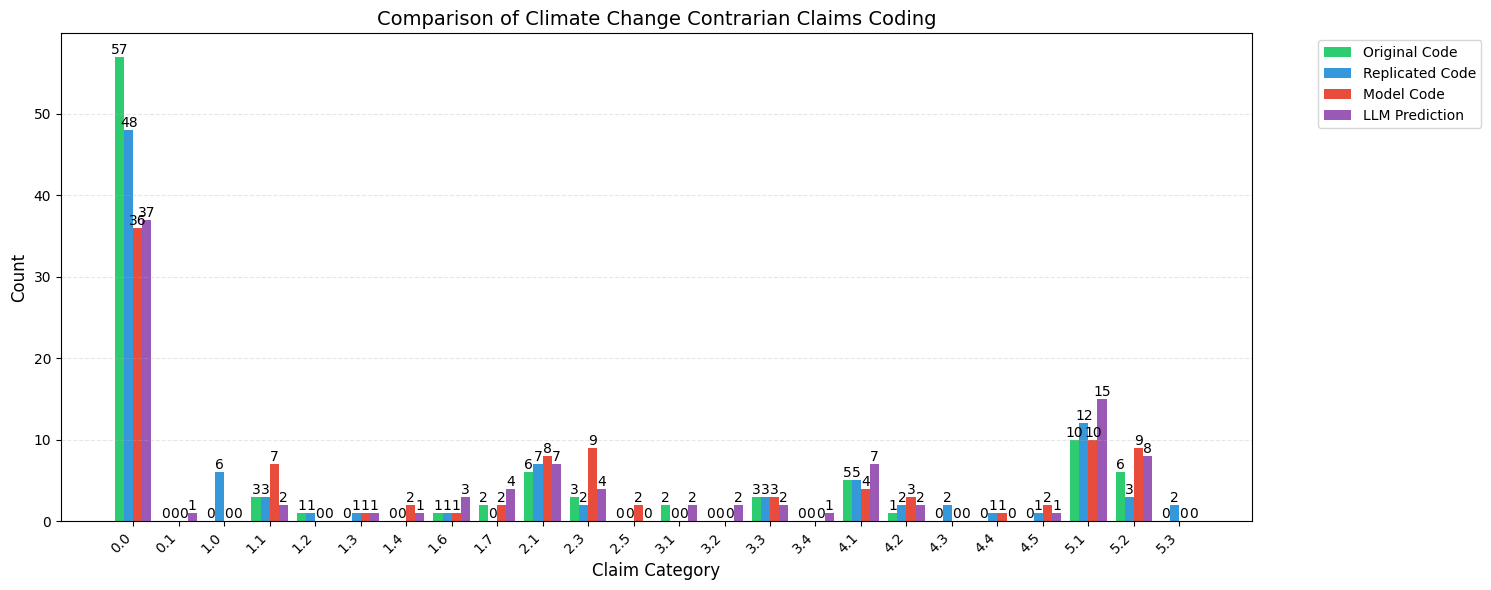

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_code_comparison(df_results):
    """
    Create a bar plot comparing distributions across different codings.
    """
    # Convert all codes to strings for consistency
    df_temp = df_results.copy()
    df_temp['original_code'] = df_temp['original_code'].astype(str)
    df_temp['replicated_code'] = df_temp['replicated_code'].astype(str)
    df_temp['model_code'] = df_temp['model_code'].astype(str)
    
    # Get all unique categories across all columns
    categories = sorted(set(df_temp['original_code']) | 
                       set(df_temp['replicated_code']) | 
                       set(df_temp['model_code']) | 
                       set(df_temp['model_prediction']))
    
    # Get value counts for each column, reindex to include all categories
    original_counts = df_temp['original_code'].value_counts().reindex(categories).fillna(0)
    replicated_counts = df_temp['replicated_code'].value_counts().reindex(categories).fillna(0)
    model_counts = df_temp['model_code'].value_counts().reindex(categories).fillna(0)
    prediction_counts = df_temp['model_prediction'].value_counts().reindex(categories).fillna(0)
    
    # Number of categories and set up plot
    n = len(categories)
    x = np.arange(n)
    width = 0.2  # Width of the bars
    
    # Create plot
    plt.figure(figsize=(15, 6))
    
    # Create bars
    b1 = plt.bar(x - 1.5*width, original_counts, width, label='Original Code', color='#2ecc71')
    b2 = plt.bar(x - 0.5*width, replicated_counts, width, label='Replicated Code', color='#3498db')
    b3 = plt.bar(x + 0.5*width, model_counts, width, label='Model Code', color='#e74c3c')
    b4 = plt.bar(x + 1.5*width, prediction_counts, width, label='LLM Prediction', color='#9b59b6')
    
    # Customize plot
    plt.xlabel('Claim Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Comparison of Climate Change Contrarian Claims Coding', fontsize=14)
    plt.xticks(x, categories, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')
    
    add_value_labels(b1)
    add_value_labels(b2)
    add_value_labels(b3)
    add_value_labels(b4)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

def print_coding_stats(df_results):
    """Print summary statistics about the different codings."""
    # Convert all codes to strings for consistency
    df_temp = df_results.copy()
    df_temp['original_code'] = df_temp['original_code'].astype(str)
    df_temp['replicated_code'] = df_temp['replicated_code'].astype(str)
    df_temp['model_code'] = df_temp['model_code'].astype(str)
    
    print("Distribution of codes:")
    print("\nOriginal Code:")
    print(df_temp['original_code'].value_counts().sort_index())
    print("\nReplicated Code:")
    print(df_temp['replicated_code'].value_counts().sort_index())
    print("\nModel Code:")
    print(df_temp['model_code'].value_counts().sort_index())
    print("\nLLM Prediction:")
    print(df_temp['model_prediction'].value_counts().sort_index())
    
    # Calculate agreement percentages
    total = len(df_temp)
    original_replicated_agreement = (df_temp['original_code'] == df_temp['replicated_code']).mean() * 100
    original_model_agreement = (df_temp['original_code'] == df_temp['model_code']).mean() * 100
    original_prediction_agreement = (df_temp['original_code'] == df_temp['model_prediction']).mean() * 100
    
    print("\nAgreement Percentages:")
    print(f"Original vs Replicated: {original_replicated_agreement:.1f}%")
    print(f"Original vs Model: {original_model_agreement:.1f}%")
    print(f"Original vs LLM Prediction: {original_prediction_agreement:.1f}%")

# Usage
print_coding_stats(df_results)
plt = plot_code_comparison(df_results)
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

def calculate_similarity_metrics(df_results, ground_truth_col, prediction_col):
    """
    Calculate various similarity metrics between two columns
    """
    # Remove rows where either column has missing values or errors
    valid_rows = df_results[[ground_truth_col, prediction_col]].dropna()
    valid_rows = valid_rows[valid_rows[prediction_col] != 'Error']
    
    # Convert all values to strings for comparison
    valid_rows = valid_rows.astype(str)
    
    if len(valid_rows) == 0:
        return {
            'accuracy': 0,
            'kappa': 0,
            'matching_cases': 0,
            'total_cases': 0,
            'percentage_match': 0
        }
    
    # Calculate metrics
    accuracy = accuracy_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    kappa = cohen_kappa_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    matching_cases = (valid_rows[ground_truth_col] == valid_rows[prediction_col]).sum()
    total_cases = len(valid_rows)
    percentage_match = (matching_cases / total_cases) * 100
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'matching_cases': matching_cases,
        'total_cases': total_cases,
        'percentage_match': percentage_match
    }

def analyze_code_similarities(df_results):
    """
    Analyze similarities between model outputs and human categorizations
    """
    # Comparisons to make
    comparisons = [
        ('original_code', 'model_code'),
        ('original_code', 'model_prediction'),
        ('replicated_code', 'model_code'),
        ('replicated_code', 'model_prediction')
    ]
    
    # Calculate metrics for each comparison
    results_dict = {}
    for truth_col, pred_col in comparisons:
        results_dict[f"{truth_col}_vs_{pred_col}"] = calculate_similarity_metrics(
            df_results, truth_col, pred_col
        )
    
    # Create a summary dataframe
    summary_df = pd.DataFrame({
        'Comparison': [k.replace('_', ' ').title() for k in results_dict.keys()],
        'Accuracy': [v['accuracy'] for v in results_dict.values()],
        'Kappa Score': [v['kappa'] for v in results_dict.values()],
        'Matching Cases': [v['matching_cases'] for v in results_dict.values()],
        'Total Cases': [v['total_cases'] for v in results_dict.values()],
        'Match Percentage': [v['percentage_match'] for v in results_dict.values()]
    })
    
    # Format the percentage column
    summary_df['Match Percentage'] = summary_df['Match Percentage'].round(2).astype(str) + '%'
    
    # Create detailed confusion matrices
    confusion_matrices = {}
    for truth_col, pred_col in comparisons:
        valid_rows = df_results[[truth_col, pred_col]].dropna()
        valid_rows = valid_rows[valid_rows[pred_col] != 'Error']  # Fixed: pred_col instead of prediction_col
        valid_rows = valid_rows.astype(str)
        
        if len(valid_rows) > 0:
            matrix = confusion_matrix(
                valid_rows[truth_col], 
                valid_rows[pred_col],
                labels=sorted(valid_rows[truth_col].unique())
            )
            confusion_matrices[f"{truth_col}_vs_{pred_col}"] = matrix
    
    return summary_df, confusion_matrices

# Run the analysis
summary_df, confusion_matrices = analyze_code_similarities(df_results)

# Display the results
print("\nSimilarity Analysis Summary:")
print("=" * 100)
print(summary_df.to_string(index=False))
print("\nDetailed Analysis:")
print("=" * 100)

# Determine which model is more similar to human coding
original_code_comparison = summary_df[summary_df['Comparison'].str.contains('Original Code')]
replicated_code_comparison = summary_df[summary_df['Comparison'].str.contains('Replicated Code')]

print("\nComparison with Original Code:")
better_for_original = original_code_comparison.iloc[original_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_original['Comparison']}")
print(f"Accuracy: {better_for_original['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_original['Kappa Score']:.3f}")

print("\nComparison with Replicated Code:")
better_for_replicated = replicated_code_comparison.iloc[replicated_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_replicated['Comparison']}")
print(f"Accuracy: {better_for_replicated['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_replicated['Kappa Score']:.3f}")

# Print confusion matrices with labels
for name, matrix in confusion_matrices.items():
    print(f"\nConfusion Matrix for {name}:")
    truth_col = name.split('_vs_')[0]
    categories = sorted(df_results[truth_col].astype(str).unique())
    print("\nCategories:", categories)
    print(matrix)


Similarity Analysis Summary:
                         Comparison  Accuracy  Kappa Score  Matching Cases  Total Cases Match Percentage
        Original Code Vs Model Code      0.61     0.490928              61          100            61.0%
  Original Code Vs Model Prediction      0.70     0.603960              70          100            70.0%
      Replicated Code Vs Model Code      0.56     0.449312              56          100            56.0%
Replicated Code Vs Model Prediction      0.58     0.468825              58          100            58.0%

Detailed Analysis:

Comparison with Original Code:
Better model: Original Code Vs Model Prediction
Accuracy: 70.00%
Kappa Score: 0.604

Comparison with Replicated Code:
Better model: Replicated Code Vs Model Prediction
Accuracy: 58.00%
Kappa Score: 0.469

Confusion Matrix for original_code_vs_model_code:

Categories: ['0.0', '1.1', '1.2', '1.6', '1.7', '2.1', '2.3', '3.1', '3.3', '4.1', '4.2', '5.1', '5.2']
[[35  2  0  0  2  1  2  0  1  1  

In [17]:
df_results.to_csv('climate_prompt_results_final.csv', index=False)
print("Results saved to climate_claims_results.csv")

Results saved to climate_claims_results.csv
